# Evaluate Printer Log Usage
This notebook is just an automated way to report on 3D printer usage. It expects the latest data file to be downloaded locally, whatever the source.

## Check Environment
I usually run these kind of notebooks in isolated virtual environments, This next bit of code check to make sure that the Python kernel is in the location associated with that virtual environment (only you can tell.) and the Python version.

In [167]:
import sys, os
print("cwd:{}".format(os.getcwd()))
print("exe:{}".format(sys.executable))
print("ver:{}".format(sys.version))

cwd:/home/rgordon/projects/barn-printer-logs/notebooks
exe:/home/rgordon/projects/barn-printer-logs/pyenv/bin/python3
ver:3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


## Standard Imports
I'll put all of the libraries/packages that we use in the notebook in this section, so you determine quickly whether there's anything missing.

In [168]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# let seaborn overwrite standard plt
sns.set()

## Load and Prep the Data
Npw we need to load and prepare the data for downstream usage. We'll check it here and apply what's needed. I'd expect this area to evolve as data grows in complexity or requirements.

In [169]:
DATA_DIR = os.path.join("..","data")
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".tsv")]
print(files)

['printer-logs.tsv']


In [170]:
df_raw = pd.read_csv(os.path.join(DATA_DIR, files[0]), sep='\t')

In [171]:
print("Shape of loaded data is {}".format(df_raw.shape))
print(df_raw.columns)
print(df_raw.index)
# columns can have whitespace around them - kill it
df_raw.columns = df_raw.columns.str.strip()
df_raw.head()

Shape of loaded data is (20, 12)
Index(['date', 'name', 'filament', 'days', 'hours ', 'mins', 'z offset',
       'self test passed', 'belt x', 'belt y', 'usage hrs (calc) ', 'notes'],
      dtype='object')
RangeIndex(start=0, stop=20, step=1)


,date,name,filament,days,hours,mins,z offset,self test passed,belt x,belt y,usage hrs (calc),notes
0,2019-10-24,Prusa 01,5118.88,327.0,13.0,50.0,NaN,y,NaN,NaN,7861.8,NaN
1,2019-10-24,Prusa 02,5855.92,243.0,2.0,52.0,NaN,y,NaN,NaN,5834.9,NaN
2,2019-10-24,Prusa 03,3490.80,350.0,0.0,58.0,NaN,y,NaN,NaN,8401.0,NaN
3,2019-10-24,Prusa 05,1147.71,41.0,15.0,17.0,NaN,y,NaN,NaN,999.3,NaN
4,2019-11-07,Prusa 01,5122.33,327.0,21.0,6.0,-0.99,NaN,NaN,NaN,7869.1,NaN


We will not need all of these columns at present, so let's extract the ones we do need as a separate copy that we can manipulate as needed. Let's recreate the duration value in hours to be sure its correct.

In [172]:
df_printers = df_raw[['date','name','filament','days','hours','mins']].copy()
# one way to do this by using dataframe-specific operations, pretty straight-forward
df_printers['usage_hrs'] =  round(
    (df_printers['days'] * 24) + (df_printers['hours']) + (df_printers['mins'] / 60),1)
"""
# another way is to apply a function across all rows, generating a list which makes a new column
# it's probalby more 'Pythonic' but is certainly less clear. this also demonstrated how properly-defined
# index names can be used directly as with a dictionary.
df_printers['test'] = df_printers.apply(
        lambda row: round((row.days * 24) + (row.hours) + (row.mins/60),1), axis = 1) 
"""
df_printers.head()

,date,name,filament,days,hours,mins,usage_hrs
0,2019-10-24,Prusa 01,5118.88,327.0,13.0,50.0,7861.8
1,2019-10-24,Prusa 02,5855.92,243.0,2.0,52.0,5834.9
2,2019-10-24,Prusa 03,3490.80,350.0,0.0,58.0,8401.0
3,2019-10-24,Prusa 05,1147.71,41.0,15.0,17.0,999.3
4,2019-11-07,Prusa 01,5122.33,327.0,21.0,6.0,7869.1


If any of the rows have no values in the columns we care about, we can detect and filter them out. We could inspect and determine whether there are specific columns to check or we can just filter them all out.

In [173]:
print(df_printers[df_printers['filament'].isnull()])
print(df_printers[df_printers['usage_hrs'].isnull()])

          date      name  filament  days  hours  mins  usage_hrs
14  2019-11-23  Prusa 03       NaN   NaN    NaN   NaN        NaN
          date      name  filament  days  hours  mins  usage_hrs
14  2019-11-23  Prusa 03       NaN   NaN    NaN   NaN        NaN


In [174]:
# we can either drop just the subset of nulls or we can drop any of them where there is a null column value
#df_printers = df_printers.dropna(subset=['filament','usage_hrs'])
df_printers = df_printers.dropna()
df_printers.head()

,date,name,filament,days,hours,mins,usage_hrs
0,2019-10-24,Prusa 01,5118.88,327.0,13.0,50.0,7861.8
1,2019-10-24,Prusa 02,5855.92,243.0,2.0,52.0,5834.9
2,2019-10-24,Prusa 03,3490.80,350.0,0.0,58.0,8401.0
3,2019-10-24,Prusa 05,1147.71,41.0,15.0,17.0,999.3
4,2019-11-07,Prusa 01,5122.33,327.0,21.0,6.0,7869.1


Finally, let's canonicalize names, and make sure dates are actually Date objects.

In [175]:
# dates are easy enough
df_printers['date'] = pd.to_datetime(df_printers['date'], format='%Y-%m-%d')

#printer names - let's just make them consistent for now
df_printers['name'] = pd.Series(df_printers['name']).str.capitalize()

df_printers.head()

,date,name,filament,days,hours,mins,usage_hrs
0,2019-10-24,Prusa 01,5118.88,327.0,13.0,50.0,7861.8
1,2019-10-24,Prusa 02,5855.92,243.0,2.0,52.0,5834.9
2,2019-10-24,Prusa 03,3490.80,350.0,0.0,58.0,8401.0
3,2019-10-24,Prusa 05,1147.71,41.0,15.0,17.0,999.3
4,2019-11-07,Prusa 01,5122.33,327.0,21.0,6.0,7869.1


## Reporting
We do not have a lot of data to work with here, but we do date, printer name, and usage, so that's what we can summarize.
Specifically we want to calculate:
* overall usage in terms of filament and time
* individual printer usage in terms of filament and time

In [176]:
df_by_date = df_printers.groupby(['date'])['filament','usage_hrs'].sum()
df_by_date.head()

,filament,usage_hrs
date,,
2019-10-24,15613.31,23097.0
2019-11-07,18140.76,28158.7
2019-11-14,18197.64,28195.7
2019-12-14,18516.32,29502.0


In [177]:
df_by_name = df_printers.groupby(['name'])['filament','usage_hrs'].sum()
df_by_name.head()

,filament,usage_hrs
name,,
Prusa 01,20544.78,31243.4
Prusa 02,23491.63,23383.2
Prusa 03,14003.43,33619.3
Prusa 04,7569.21,16518.2
Prusa 05,4858.98,4189.3


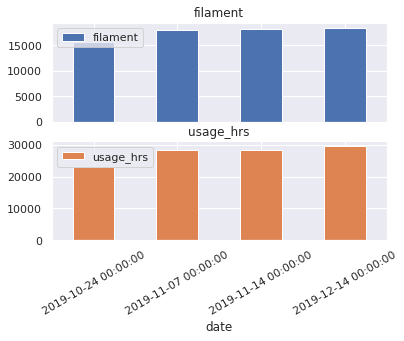

In [178]:
#fig, ax = plt.subplots(figsize=(15,7))
#ax.xaxis_date()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes = df_by_date.plot.bar(subplots=True,rot=30)
axes[0].legend(loc=2)
axes[1].legend(loc=2)
plt.show()

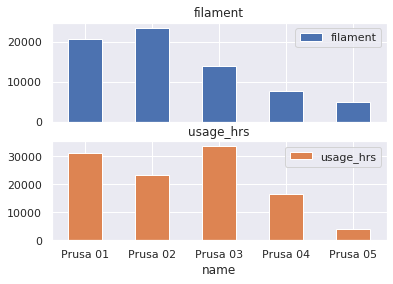

In [179]:
df_by_name.plot.bar(subplots=True,rot=0)
plt.show()

In [180]:
df_by_date.diff()

,filament,usage_hrs
date,,
2019-10-24,NaN,NaN
2019-11-07,2527.45,5061.7
2019-11-14,56.88,37.0
2019-12-14,318.68,1306.3
